## HCDS-A2-BIAS 
### Exploratory Data Analysis of Wikipedia Pages
### Rahul Birmiwal 
### HCDE 512, University of Washington

### Introduction

In this report, potential (or lackthereof) biases in Wikipedia pages are explored. Data is collected from various sources: data of Wikipages of political leaders, for all countries globally; population data for all countries; moreoever a "scoring" mechanism from the ORES machine learning service which classifies articles on "article quality" (https://www.mediawiki.org/wiki/ORES). Probing for potential bias(es) is then done using quantitative/statistcal approaches, as well as some cursory observations about the resultant countries and the unique characteristics about their geographic/history (assumed to be general knowledge). Again with the understanding/assumption here that the "bias-proxy" used  revolves around articles about political leaders. No other datasets, other than that required by this assignment, are utilized in the probing for bias.  

The instructions and walkthrough guide for this assignment can be found https://wiki.communitydata.cc/Human_Centered_Data_Science_(Fall_2018)/Assignments#A2:_Bias_in_data

### Sections

The sections in this report are as follows: 
1. Data Gathering 
2. Data Merging 
3. Results (as specified by assignment instructions)
4. Analysis I: Statistical Approach To Bias Measurement
5. Analysis II: General Observations With Respect to Geography/History


- Section Analysis I seeks to answer the question: "is there bias in the dataset?"
- Section Analysis II seeks to answer the question: "are there certain countries whose srticle content is biased?"


### Dependencies 

This report uses Python 3.X. Sections 1-4 require dependencies below. Note that the standard Python ML library`scikit-learn` is required and may have to be installed. 

In [131]:
import numpy as np 
import pandas as pd 
import requests 
import json 
import csv 
from matplotlib import pyplot as plt 
from pandas.plotting import table
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.cluster import KMeans

# I. Data Gathering 

Below are functions used to gather data. They are: 
1. `get_master()`: Used if the master (merged) data has already been generated. Pointless function otherwise 
2. `get_wikipages_df()`: This function takes 'page_data.csv' (more on that below), and returns a dataframe of <country, revision_id, article name> tuples, where: 

    - *revision_id* is like the primary key of that given article 
    - *country* is where article is from. 
    - *article name*: Name of article (aka which politician to which it pertains)

    This data comes from https://figshare.com/articles/Untitled_Item/5513449, as designated by assignment instructions

3. `get_population_df()`: Returns a dataframe of <country, population> pairs. Data comes from https://www.dropbox.com/s/5u7sy1xt7g0oi2c/WPDS_2018_data.csv?dl=0 as designated by assignment instructions

In [2]:
def get_master(): 
    try: 
        master_data = pd.read_csv('master_data.csv')
        print(master_data.head())
        return master_data 
    except(FileNotFoundError): 
        print("No file found, returning None")
        return None
    

def get_wikipages_df(): 
    pages_df = pd.read_csv('page_data.csv')
    pages_df['country'] = pages_df['country'].str.upper()
    print(pages_df.head())
    return pages_df 

def get_population_df(): 
    pop_df = pd.read_csv('WPDS_2018_data.csv')
    pop_df['Geography'] = pop_df['Geography'].str.upper()
    pop_df = pop_df.rename(index=str, columns={'Population mid-2018 (millions)':"population"})
    print(pop_df.head())
    return pop_df

Call the functions and get the data. Note that get_master() will return None if the data hasn't been gathered. Here it is called because said data has already been generated; a walkthrough on how to do so is in Data Gathering, etc. sections. 

In [200]:
# get master data. This function WILL RETURN NONE if initial data gathering 
# steps have not been previously done
master_data = get_master()

<bound method NDFrame.head of        Unnamed: 0                       page     country     rev_id  \
0               0             Bir I of Kanem        CHAD  355319463   
1               1       Abdullah II of Kanem        CHAD  498683267   
2               2        Salmama II of Kanem        CHAD  565745353   
3               3            Kuri I of Kanem        CHAD  565745365   
4               4        Mohammed I of Kanem        CHAD  565745375   
5               5           Kuri II of Kanem        CHAD  669719757   
6               6            Bir II of Kanem        CHAD  670893206   
7               7            Mahamat Hissene        CHAD  693055898   
8               8                   Othman I        CHAD  705432607   
9               9            Alphonse Kotiga        CHAD  707593108   
10             10          Oueddei Kichidemi        CHAD  708346649   
11             11                   Dunama I        CHAD  710675092   
12             12   Ahmad (Kanem-Bornu king)   

In [8]:
# get population data 
pop_df = get_population_df()

  Geography population
0    AFRICA      1,284
1   ALGERIA       42.7
2     EGYPT         97
3     LIBYA        6.5
4   MOROCCO       35.2


In [9]:
# get pages data 
pages_df = get_wikipages_df()

                                 page   country     rev_id
0  Template:ZambiaProvincialMinisters    ZAMBIA  235107991
1                      Bir I of Kanem      CHAD  355319463
2   Template:Zimbabwe-politician-stub  ZIMBABWE  391862046
3     Template:Uganda-politician-stub    UGANDA  391862070
4    Template:Namibia-politician-stub   NAMIBIA  391862409


Since many queries/accesses of data from these various sources will be used extensively, it can be easier to work with dictionaries rather than data frames. Here we create a dictionary of the population data and appropriately parse the string representation of the (quantitative) population number to float. 

In [10]:
pop_dict = pop_df.set_index('Geography')['population'].to_dict()
pop_dict = dict(zip(pop_dict.keys(), [float(value.replace(',','')) for value in pop_dict.values()]))

### Retrieving Wikipage Data From ORES API 

Other data needed to be gathered is the ORES data. Python code below is taken and/or adapted from https://github.com/Ironholds/data-512-a2. Two functions are used below: 

- `get_ores_data()`: Takes a *subsetted* list of revision_ids (from `get_wikipages_df` data source) and returns JSON file obtained by call to `requests()`. Note that the length of the revision_ids list, should not be too big. Here we take size of 100, hence calling it a subsetted list. 
    
- `get_revisionID_predictions()`: The function takes a *full* list of the revision ids, calls `get_ores_data` in chunks, and aggregates the resultant JSON outputs into a new dictionary, which is the complete set of <revision_id, prediction> pairs, where *prediction* is the eponyomously labeled field in the JSON output from `get_ores_data`. Please note that due to the JSON structure, we have to dig a little deep in each JSON subtree to get the pertinent data for such pairs. 

### JSON Structure of the ORES Data 

For reference to the reader: 
Pulled from https://github.com/Ironholds/data-512-a2.

`
{
    "enwiki": {
        "models": {
            "wp10": {
                "version": "0.5.0"
            }
        },
        "scores": {
            "757539710": {
                "wp10": {
                    "score": {
                        "prediction": "Start",
                        "probability": {
                            "B": 0.0950995993086368,
                            "C": 0.1709859524092081,
                            "FA": 0.002534267983331672,
                            "GA": 0.005731369423122624,
                            "Start": 0.7091352495053856,
                            "Stub": 0.01651356137031511
                        }
                    }
                }
            },
 `

In [37]:

headers = {'User-Agent' : 'https://github.com/rrbirmiw/data-512-a2', 'From' : 'rrbirmiw@uw.edu'}

def get_ores_data(revision_ids, headers):
    
    # Define the endpoint
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    # Specify the parameters - smushing all the revision IDs together separated by | marks.
    # Yes, 'smush' is a technical term, trust me I'm a scientist.
    # What do you mean "but people trusting scientists regularly goes horribly wrong" who taught you tha- oh.  
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    return(response)



In [38]:
def get_revisionID_predictions(rev_ids, chunk_size=100): 
    """
    Returns dictionary of <rev_id, prediction> key-value pairs
    
    Args: 
    - rev_ids (list of ints): Full List of revision id's, each datum is int 
    - chunk_size (int): Default 100; size of each chunk to be run through 
                        get_ores_data() API call
    Returns: 
    - predictions_dict (dictionary)
    """
    
    # print counter for debugging purposes 
    counter = 0
    chunk_num = 0
    
    #break data into chunks of chunk_Size so don't overload ORES requests
    splits = len(rev_ids) // chunk_size 
    chunks = np.array_split(rev_ids, splits)
 
    predictions_dict = {} # dictionary to store <rev_id, pred> pairs 
    
    # loop through chunks, inserting resultant data into predictions_dict
    for c in chunks: 
        counter += len(c)
        chunk_num += 1
        if counter % 1000 == 0: print("Completed {}".format(counter))
        try:
            ores_json =  get_ores_data(c, headers)
        except ValueError as e:
            print("Error occured on chunk{}......{}".format(chunk_num, e))
            continue # admitting that continue here will skip remained of the chunk. 
                     # However...a ValueError (JSONDecodeError) should not occur
                     # this is just to be safe 
            
        # Parse the JSON tree structure
        # come articles may have missing data, so ensure that each 
        # tree "node" / key is present along the way 
        if 'enwiki' in ores_json: 
            ores_data = ores_json['enwiki']
            if 'scores' in ores_data: 
                ores_dict = ores_data['scores']
                for rid in ores_dict: 
                    z = ores_dict[rid]['wp10']
                    if 'score' in z: 
                        predictions_dict[rid] = z['score']['prediction']  
                    
    return predictions_dict

Now get the full ORES data. May take several minutes. 

In [ ]:
# convert revision ids to integers datatype 
revision_ids = list(map(int, pages_df['rev_id'].tolist()))

# get the ORES data for all ids 
pred_data = get_revisionID_predictions(revision_ids)

Convert the prediction data dictionary to pandas dataframe. Rename the columns appropriately and ensure the revision_id column is again of type int. Then save this to csv file so don't have to come back again

In [101]:
pred_data_df = pd.DataFrame.from_dict(pred_data, orient='index').reset_index()
pred_data_df = pred_data_df.rename(index=str, columns={"index":'rev_id', 0:'prediction'})
pred_data_df['rev_id'] = list(map(int, pred_data_df['rev_id']))
pred_data_df.to_csv("predictions_data.csv")


# 2. Data Merging 

Now begin merging the various dataframes into a master_data Pandas dataframe. As per assignment instructions, inner join is performed on all merges, disregarding revision_ids lacking a "full" set of information. (and vice versa, disregarding those ORES data not in this report's set of revision_ids, as created in the aformentioned Figshare link above)

In [103]:
# merge Wikipages dataframe with the prediction data
master_data = pages_df.merge(pred_data_df, on='rev_id',how='inner')

In [105]:
# merge master with population data
master_data = master_data.merge(pop_df, left_on='country', right_on='Geography', how='inner')

In [123]:
# rename the longwinded population column to something easier. Fix other column names as well. 
master_data = master_data.rename(index=str, columns={'Population mid-2018 (millions)':"population"})

In [209]:
# save to CSV for easier reuse
master_data = master_data.rename(index=str, columns={'Geography':"Country", 'page':'article-name'})
master_data.to_csv('master_data.csv')

In [210]:
master_data.head()

,Unnamed: 0,article-name,country,rev_id,prediction,Country,population
0,0,Bir I of Kanem,CHAD,355319463,Stub,CHAD,15.4
1,1,Abdullah II of Kanem,CHAD,498683267,Stub,CHAD,15.4
2,2,Salmama II of Kanem,CHAD,565745353,Stub,CHAD,15.4
3,3,Kuri I of Kanem,CHAD,565745365,Stub,CHAD,15.4
4,4,Mohammed I of Kanem,CHAD,565745375,Stub,CHAD,15.4


# 3. Results and Tables 

Assignment instructions state the following tables must be produced: 

"
The tables should be pretty straightforward. Produce four tables that show:

- 10 highest-ranked countries in terms of number of politician articles as a proportion of country population
- 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
- 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
- 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
" (https://wiki.communitydata.cc/Human_Centered_Data_Science_(Fall_2018)/Assignments#A2:_Bias_in_data)

In order to do so, two fields must be created: 
1. **Articles-Per-Population Percentage**: defined to be number of articles about politicians for that country divided by country population (in units of millions) times 100
2. **Good-Article Percentage**: define to be number of "good articles" divided by number of total articles for each country, times 100. As defined by assignment instructions, a "good article" is one that receives a "FA" or "GA" prediction score in the ORES dataset. 

A SQL type query that would generate the the number of "good-articles" for a country is shown below. That query is then translated into pandas dataframe operations. 

```
SELECT country, count(*) as num_articles
FROM master_data 
WHERE prediction in ('FA', 'GA')
GROUP BY country 
```

Create two dataframes, one for the good articles which will contain <country, good-article-count> tuples, where good-article-count is defined above. Likewise create all_articles dataframe, which will contain <country, total articles for that country politicians> tuples. 

In [4]:
good_articles = pd.DataFrame(master_data[master_data['prediction'].isin(['FA','GA'])]).groupby('country').size()
good_articles = good_articles.reset_index().rename(index=str, columns={0:'good-article-count'})

all_articles = master_data.groupby('country').size()
all_articles = all_articles.reset_index().rename(index=str, columns={0:'total-articles'})

View them...

In [5]:
good_articles.head()

,country,good-article-count
0,AFGHANISTAN,10
1,ALBANIA,4
2,ALGERIA,2
3,ARGENTINA,15
4,ARMENIA,5


In [6]:
all_articles.head()

,country,total-articles
0,AFGHANISTAN,326
1,ALBANIA,460
2,ALGERIA,119
3,ANDORRA,34
4,ANGOLA,110


Again, easier to work in dictionary datatype, so convert above dataframes to dictionary analogs. 
Then using that create the first required field, *articles-per-population* by creating a dictionary of <country, articles-per-population> pairs, noting that the population units are in millions.

In [119]:
# create dictionary analogs 
good_article_dict = good_articles.set_index('country')['good-article-count'].to_dict()
total_article_dict = all_articles.set_index('country')['total-articles'].to_dict()

# create article-percentages dictionary 
article_percentages = {c: 100/1e6*(total_article_dict[c]/pop_dict[c]) for c in total_article_dict}

# create article-percentages dataframe for easy tabular viewing
article_perc_df = pd.DataFrame.from_dict(article_percentages, orient='index')
article_perc_df = article_perc_df.reset_index().rename(index=str, columns={'index': 'Country',0:'article-percentage'})

View some of the percentages

In [120]:
article_perc_df.head()

,Country,article-percentage
0,AFGHANISTAN,0.000893
1,ALBANIA,0.015862
2,ALGERIA,0.000279
3,ANDORRA,0.042500
4,ANGOLA,0.000362


It's also important to verify the data is correct. To do take Bosnia-Herzegovina as an example. The article-percentage for this one is 0.005. Now look at all entries in the dictionary for that country, and check the math

In [16]:
# Test results 

#Bosnia-Herzegovina 
x = master_data[master_data['country'] == 'BOSNIA-HERZEGOVINA']
print("Bosnia-Herzegovina has {} rows".format(x.shape[0]))
x.head()

Bosnia-Herzegovina has 177 rows


,Unnamed: 0,page,country,rev_id,prediction,Geography,population
36970,36970,Template:BosniaHerzegovina-mayor-stub,BOSNIA-HERZEGOVINA,540988222,Stub,BOSNIA-HERZEGOVINA,3.5
36971,36971,Template:BosniaHerzegovina-diplomat-stub,BOSNIA-HERZEGOVINA,540993917,Stub,BOSNIA-HERZEGOVINA,3.5
36972,36972,Template:Prime Ministers of Republika Srpska,BOSNIA-HERZEGOVINA,648935308,Stub,BOSNIA-HERZEGOVINA,3.5
36973,36973,Template:Prime Ministers of the Federation of ...,BOSNIA-HERZEGOVINA,651745952,Stub,BOSNIA-HERZEGOVINA,3.5
36974,36974,Aljoša Čampara,BOSNIA-HERZEGOVINA,660884852,Start,BOSNIA-HERZEGOVINA,3.5


We can see that Bosnia-Hercegovina has 3.5 M people as of this timestamp, and 177 total articles. 
- 177/3.5e6 * 100 = .005 

Correct!

Now pertinent to the dictionary for *good-article* counts, note that some countries are not present in this list, for whatever reason. Perhaps there were no FA/GA articles for said country, etc. Examine that "missing" list below: 

In [17]:
# find set difference

setGood = set(good_article_dict.keys())
setAll = set(total_article_dict.keys())
setAll - setGood

{'ANDORRA',
 'ANGOLA',
 'ANTIGUA AND BARBUDA',
 'BAHAMAS',
 'BARBADOS',
 'BELGIUM',
 'BELIZE',
 'CAMEROON',
 'CAPE VERDE',
 'COMOROS',
 'COSTA RICA',
 'DJIBOUTI',
 'FEDERATED STATES OF MICRONESIA',
 'FINLAND',
 'GUYANA',
 'KAZAKHSTAN',
 'KIRIBATI',
 'LESOTHO',
 'LIECHTENSTEIN',
 'MACEDONIA',
 'MALTA',
 'MARSHALL ISLANDS',
 'MOLDOVA',
 'MONACO',
 'MOZAMBIQUE',
 'NAURU',
 'NEPAL',
 'SAN MARINO',
 'SAO TOME AND PRINCIPE',
 'SEYCHELLES',
 'SLOVAKIA',
 'SOLOMON ISLANDS',
 'SWITZERLAND',
 'TUNISIA',
 'TURKMENISTAN',
 'UGANDA',
 'ZAMBIA'}

In the analysis section, this set of "missing" countries is analyzed in the broader probing of bias and role of geolocation

Last but not least, create dictionary and dataframe for the percentage of good-articles of total articles for that country, as required by assignment.

In [18]:
good_article_percentages = {c: 100*(good_article_dict[c] / total_article_dict[c]) for c in good_article_dict}
good_article_df = pd.DataFrame.from_dict(good_article_percentages, orient='index')
good_article_df = good_article_df.reset_index().rename(index=str,columns={'index':'country', 0:'good-art-perc'})

# 4. Results

The required 4 tables are produced below. Code will generate a .png file for each of the "top (bottom) 10" tables. Then the 4 tables are showed as one at the end of this section.  

## i. 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

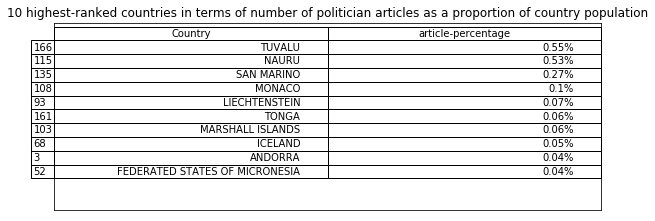

In [94]:
# Get top 10 
t1 = article_perc_df.sort_values(by=['article-percentage'],ascending=False).head(10)

# convert percentage column to formatted string 
t1['article-percentage'] = list(map(lambda x: str(round(x,2))+"%", t1['article-percentage'].tolist()))

# Save to .png file. 
# Adapted from https://stackoverflow.com/questions/44751045/save-pandas-table-filled-with-strings-as-png
fig,ax = plt.subplots(figsize=(8,3))
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, t1, loc='upper center') 
tab.auto_set_font_size(False)
tab.set_fontsize(10) 
fig.tight_layout()
plt.title("10 highest-ranked countries in terms of number of politician articles as a proportion of country population")
plt.savefig('highest-rank-by-article-percentage.png')


## ii. 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

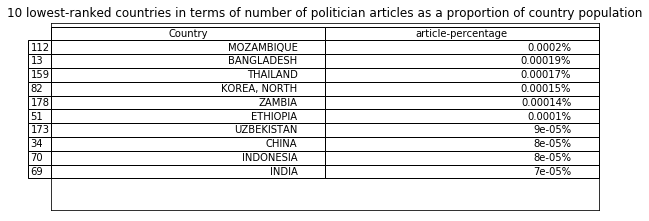

In [95]:
# Get bottom 10 
t1 = article_perc_df.sort_values(by=['article-percentage'],ascending=False).tail(10)

# convert percentage column to formatted string 
t1['article-percentage'] = list(map(lambda x: str(round(x,5))+"%", t1['article-percentage'].tolist()))

# Save to .png file. 
# Adapted from https://stackoverflow.com/questions/44751045/save-pandas-table-filled-with-strings-as-png
fig,ax = plt.subplots(figsize=(8,3))
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, t1, loc='upper center') 
tab.auto_set_font_size(False)
tab.set_fontsize(10) 
fig.tight_layout()
plt.title("10 lowest-ranked countries in terms of number of politician articles as a proportion of country population")
plt.savefig('lowest-rank-by-article-percentage.png')



## iii. 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

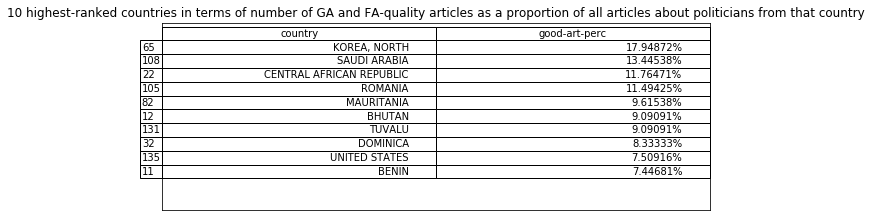

In [96]:
# Get top 10 
t1 = good_article_df.sort_values(by=['good-art-perc'],ascending=False).head(10)

# convert percentage column to formatted string 
t1['good-art-perc'] = list(map(lambda x: str(round(x,5))+"%", t1['good-art-perc'].tolist()))

# Save to .png file. 
# Adapted from https://stackoverflow.com/questions/44751045/save-pandas-table-filled-with-strings-as-png
fig,ax = plt.subplots(figsize=(8,3))
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, t1, loc='upper center') 
tab.auto_set_font_size(False)
tab.set_fontsize(10) 
fig.tight_layout()
plt.title("10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country")
plt.savefig('highest-rank-by-good-articles.png')




## iv. 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

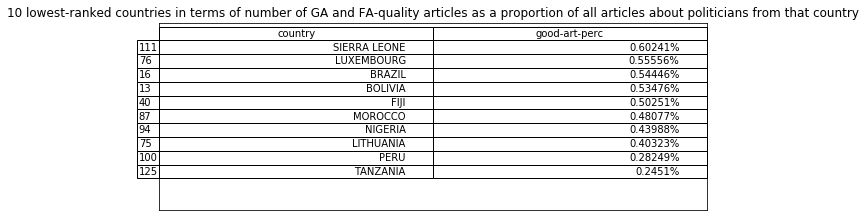

In [97]:
# Get bottom 10 
t1 = good_article_df.sort_values(by=['good-art-perc'],ascending=False).tail(10)

# convert percentage column to formatted string 
t1['good-art-perc'] = list(map(lambda x: str(round(x,5))+"%", t1['good-art-perc'].tolist()))

# Save to .png file. 
# Adapted from https://stackoverflow.com/questions/44751045/save-pandas-table-filled-with-strings-as-png
fig,ax = plt.subplots(figsize=(8,3))
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, t1, loc='upper center') 
tab.auto_set_font_size(False)
tab.set_fontsize(10) 
fig.tight_layout()
plt.title("10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country")
plt.savefig('lowest-rank-by-good-articles.png')





### Tables Summary: 

In [98]:
display(HTML("<tr><td><img src='highest-rank-by-good-articles.png'></td> \
             <td><img src='lowest-rank-by-good-articles.png'></td></tr>"))

,


In [99]:
display(HTML("<tr><td><img  src='highest-rank-by-article-percentage.png'></td> \
             <td><img  src='lowest-rank-by-article-percentage.png'></td></tr>"))

,


# 5. Analysis I: Clustering and Z Scores

Again, this report seeks to probe for bias based the following factors: 
- population 
- article-percentage, henceforth called AP
- good article-percentage of all articles, henceforth called GAP
- country
- geography (see following section)
- general knowledge 

Henceforth, report will refer to Good-Article-Percentage as GAP and Article Percentage (of population) as APOP
Given this set, this report makes the assumption that bias manifests through a statistical framework. Consider the following scenario: 

Suppose a country X has population of 100,000. Total number of Wiki articles for politicians in X is 1000. Then APOP is 1. Now say X's GAP percentage is 50%, that is it has 500 GA/FA articles. Now, suppose there exist other countries whose APOPs ~= 1

We define bias to (qualitatively) exist if: **the z-score of X's GAP value, within the context/samples of the GAP values of its peer group -- where the peer group is the set of all countries with APOP ~=1 (in this example) -- is large, particularly greater than the standard thresholding value of 2. **

This definition may be subject to debate, but the author of this report deemed it intuitive enough, and since the exploration of bias is limited to those 6 criteria, thought it was apropos given the "constraints" and scope of this assignment. 

The steps needed to produce this analysis are: 
1. Create a data frame of <article-percentage, country_id> pairs as string datatype cannot be used in a KMeans classifier
2. Establish the mapping between country_id and country names
3. Create and train a scikit-learn KMeans classifier with 10 clusters on the set of article-percentage values
4. Create function to determine which country_ids (and by extension which countries) are in each cluster, after training of the classifier. This allows us to retrieve each country's PEER GROUP
5. Create function that takes as input a country name X, and obtain the GAP scores of each country in X's PEER GROUP, and then returns the z-score of X's individual GAP score, within the context of that PEER GROUP
6. Run function in step 5 for all countries in the master dataset to obtain a dataframe comprised of *(COUNTRY NAME, GAP-PEERGROUP Z SCORE)* pairs 
7. Examine the distribution of the GAP-PEERGROUP Z scores. If there are fat tails (i.e. there are a lot of countries with very high scores and vice versa), then we say there is bias in the dataset. 



## Step 1: Modified Dataframe

In [121]:
new_art_perc_df = article_perc_df
new_art_perc_df['C_id'] = pd.Categorical(article_perc_df.Country).codes
new_art_perc_df = new_art_perc_df.drop(['Country'],axis=1)
new_art_perc_df.head()

,article-percentage,C_id
0,0.000893,0
1,0.015862,1
2,0.000279,2
3,0.042500,3
4,0.000362,4


## Step 2: Mapping and Inverse Map

Define the mapping, and an inverse mapping, of C_id to Country Name, as to be able to reference the output of the K-Means clustering (i.e. what are the C_Ids and thereby what countries) are in each cluster. 

*Note that this mapping is equivalent to the alphabetical country ordering as can be seen in the dataframe. That is *country with **C_id=N is the same as the Nth country alphabetically**

In [137]:
mapping = dict(zip(new_art_perc_df['C_id'].tolist(), article_perc_df['Country'].tolist()))
inverse_mapping = dict(zip(article_perc_df['Country'].tolist(), new_art_perc_df['C_id'].tolist()))

## Step 3: KMeans Classifier

In [158]:
# create K-Means classifier with 10 clusters (chosen arbitrarily), and fit this to the 
# article-percentage values
vals = np.array(new_art_perc_df['article-percentage']).reshape([-1,1])
kmeans = KMeans(n_clusters=10, random_state=0).fit(vals)

array([4, 5, 4, 7, 4, 5, 4, 9, 9, 9, 4, 9, 9, 4, 9, 4, 9, 9, 4, 9, 4, 9,
       9, 4, 9, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 9, 9, 9, 9, 4, 0, 9, 9,
       5, 4, 4, 4, 4, 4, 0, 4, 7, 5, 0, 9, 9, 9, 4, 4, 9, 7, 4, 4, 4, 4,
       4, 9, 3, 4, 4, 4, 4, 0, 9, 4, 9, 4, 4, 4, 4, 7, 4, 4, 9, 4, 4, 4,
       9, 9, 4, 9, 4, 3, 0, 7, 9, 4, 4, 4, 5, 4, 5, 3, 4, 9, 4, 0, 6, 9,
       0, 4, 4, 4, 9, 8, 4, 9, 5, 4, 4, 4, 0, 4, 9, 4, 4, 4, 4, 4, 9, 4,
       4, 4, 4, 2, 0, 4, 4, 9, 5, 4, 4, 4, 9, 0, 4, 4, 4, 4, 4, 4, 9, 9,
       9, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 0, 4, 5, 4,
       4, 4, 4, 4], dtype=int32)

## Step 4: Determining Peer Group and Helper Functions

Now, we will need a way to figure out what the values in each cluster index are. That is, I want to determine the Z-score of North Korea's GAP for within the context of the APOPs of its "peer group" -- peer group coming from the elements in its cluster. The function below is taken from # https://stackoverflow.com/questions/36195457/python-sklearn-kmeans-how-to-get-the-values-in-the-cluster and accomplishes that

In [154]:

def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]


As example, view the C_ids in cluster index 0

In [155]:
ClusterIndicesNumpy(0, kmeans.labels_)

array([ 41,  50,  54,  73,  94, 107, 110, 122, 136, 145, 172])

And moreover, view those countries: 

This is allowed since as discussed above, the mapping is equivalent to the country order

In [156]:
[mapping[cid] for cid in ClusterIndicesNumpy(0, kmeans.labels_) ]

['CYPRUS',
 'ESTONIA',
 'FINLAND',
 'IRELAND',
 'LITHUANIA',
 'MOLDOVA',
 'MONTENEGRO',
 'NORWAY',
 'SAO TOME AND PRINCIPE',
 'SOLOMON ISLANDS',
 'URUGUAY']

And as a sanity check, view each of the APOPs in this "peer group"

In [157]:
[article_percentages[c] for c in [mapping[cid] for cid in ClusterIndicesNumpy(0, kmeans.labels_) ]]

[0.008416666666666668,
 0.01176923076923077,
 0.010400000000000001,
 0.007775510204081633,
 0.008857142857142859,
 0.012171428571428571,
 0.012333333333333335,
 0.012415094339622642,
 0.011000000000000001,
 0.014,
 0.008285714285714287]

Looks okay...

In addition, can view which cluster index is assigned to say, North Korea: 

In [162]:
# figure out North Korea's C_id
x = new_art_perc_df[new_art_perc_df['C_id'] == inverse_mapping['KOREA, NORTH']]

# predict which cluster is assigned for NK's APOP value
cluster_index = kmeans.predict(np.array(x['article-percentage']).reshape([-1,1]))
cluster_index

array([4], dtype=int32)

At this point, we have clustered the countries based on APOP. Now need to define a function that takes, for any given country *X* and its associated *X.GAP* score, the canonical statistical z-score of *X.GAP* formed from the sample points in *X's* cluster/peer-countries based on APOP. The steps in the function are essentially the previous steps above combined into a single instruction set

In [178]:
def gap_clusterbased_zscore(country_name, km): 
    # get C_id
    cid = inverse_mapping[country_name]
    
    # get row in dataframe 
    x = new_art_perc_df[new_art_perc_df['C_id'] == cid]
    
    # get APOP value and convert to numpy 2D array as required for KMeans
    apop = np.array(x['article-percentage']).reshape([-1,1])
    
    # predict the cluster index for country_name
    cluster_index = km.predict(apop)
    
    # get peer group for country 
    peer_group = [mapping[cid] for cid in ClusterIndicesNumpy(cluster_index, km.labels_) ]
    
    # get GAP scores for each country in peer group
    # if country has a GAP
    GAP_scores = [good_article_percentages[c] for c in peer_group if c in good_article_percentages]
    
    # return the z-score based on the GAP scores 
    # of the peer group 
    # if the country does not exist, return NaN
    if (country_name in good_article_percentages): 
        my_GAP_score = good_article_percentages[country_name]
        return (my_GAP_score - np.mean(GAP_scores))/np.std(GAP_scores)
    else: 
        return float('NaN')

As an example, view the GAP-PeerGroup Z score for North Korea: 

In [179]:
gap_clusterbased_zscore("KOREA, NORTH", kmeans)

5.10758209043856

Very High!!

## Step 6. Run *get_clusterbased_zscore* on Master Dataframe

*Noting that values with nan should be discarded*

In [183]:
gap_zscore_dict = {c:gap_clusterbased_zscore(c, kmeans) for c in master_data['country'].tolist()}

/Users/rahulbirmiwal/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


As before, convert to dataframe and view results. Remove any values with nan. Save top and bottom 15 as images for reuse. 

/Users/rahulbirmiwal/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/rahulbirmiwal/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


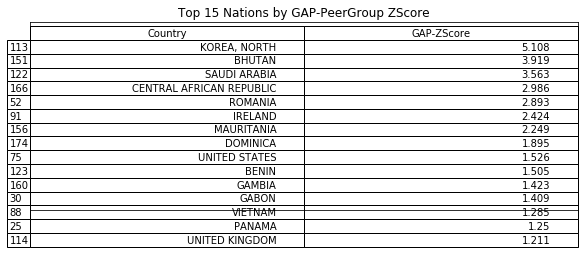

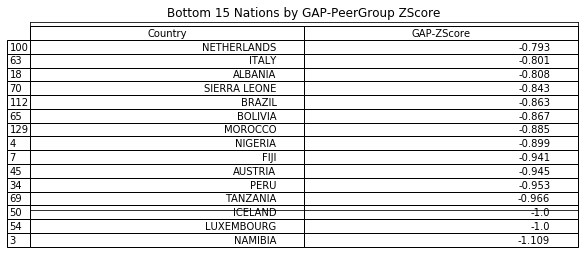

In [199]:
# convert to dataframe
gap_zscore_df = pd.DataFrame.from_dict(gap_zscore_dict, orient='index') \
            .reset_index().rename(index=str, columns={'index':'Country', 0:'GAP-ZScore'})  \
            .sort_values(by=['GAP-ZScore'],ascending=False).dropna()

# convert percentage column to formatted string 
t1 = gap_zscore_df.head(15)
t1['GAP-ZScore'] = list(map(lambda x: str(round(x,3)), t1['GAP-ZScore'].tolist()))

# like before, save to png image for resuse

# Adapted from https://stackoverflow.com/questions/44751045/save-pandas-table-filled-with-strings-as-png
fig,ax = plt.subplots(figsize=(8,3))
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, t1, loc='upper center') 
tab.auto_set_font_size(False)
tab.set_fontsize(10) 
fig.tight_layout()
plt.title("Top 15 Nations by GAP-PeerGroup ZScore")
plt.savefig('highest-by-GAP-PeerGroupScore.png')



# and likewise for the lowest 15 
t1 = gap_zscore_df.tail(15)
t1['GAP-ZScore'] = list(map(lambda x: str(round(x,3)), t1['GAP-ZScore'].tolist()))

# like before, save to png image for resuse

# Adapted from https://stackoverflow.com/questions/44751045/save-pandas-table-filled-with-strings-as-png
fig,ax = plt.subplots(figsize=(8,3))
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, t1, loc='upper center') 
tab.auto_set_font_size(False)
tab.set_fontsize(10) 
fig.tight_layout()
plt.title("Bottom 15 Nations by GAP-PeerGroup ZScore")
plt.savefig('lowest-by-GAP-PeerGroupScore.png')




## Step 7. Distribution Analysis

Examine the distribution of the GAP-ZScores. This section deals with the question "is there bias in the dataset?" as stated previously, this is done by examining said distribution and its potential deviance from the normal distribution. With the number of samples (number of countries in this case high), and by the Central Limit Theorem, assuming each country is treated "independently," our "bias-proxy" ought to be reflected by the deviance from the normal curve. 

Text(0.5,0,'GAP-ZScore')

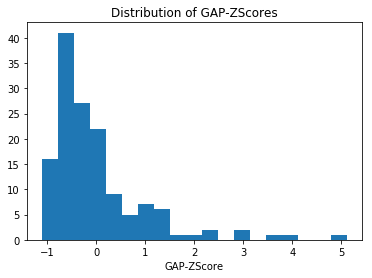

In [204]:
# get array of GAP-Zscores: 

plt.figure()
zs = np.array(gap_zscore_df['GAP-ZScore'])
plt.hist(zs, bins='auto')
plt.title("Distribution of GAP-ZScores")
plt.xlabel("GAP-ZScore")

Clearly, this distribution is NOT anything close to normal. Furthermore, it has considerable skew, with a lot of GAP-ZScore values in the > 2 regime. Based on this and assumptions prior stated, we conclude there is bias in the dataset. How that bias has arisen, is a different story and not answerable given the scope of this work. 

# Analysis 2: General Observations and Potential Geographic/Historical Sources of Bias For Individual Countries

Here we seek to answer the question if certain countries have biased data (i.e. why are certain countries have very high GAP-ZScores), from a more broader and qualititative perspective. In particular, we seek to identify if there is something unique in those countries with high GAP scores, and/or high GAP-ZScore values. The countries with high GAP scores, as identified in the Results section are: 

Analysis below should not be taken as fact, and are solely opinions of the author. 

1. North Korea
2. Saudi Arabia
3. Central African Republic
4. Romania
5. Mauritania
6. Bhutan 
7. Tuvalu
8. Dominica
9. United States
10. Benin

and countries with highest GAP-ZScores are: 

1. North Korea
2. Bhutan
3. Saudi Arabia
4. Central African Republic
5. Romania
6. Ireland
7. Mauritania 
8. Dominia
9. United States
10. Benin
11. Gambia
12. Gabon
13. Vietnam 

Certain countries, especially those that exist in both sets, stand out. Perhaps there is osmething unique about those countries that increased the relative proportion, normalized against population, for those country-articles. We look at some of those countries below and use author's assumed general knowledge to probe deeper: 

- **North Korea**: North Korea has a history of facism and government censorship of media. It has a prominent role in history, especially during the 20th century and extremely tense relationship between the United States, its policy of erecting anti-communist governments, versus the Soviet-China led bloc of which North Korea was apart. With the leaders and political climate of North Korea having been a firestorm in recent memory, it makes sense that a lot of North Korea's articles are featured. Perhaps also government censorship/intervention into free speech has played a role. 

- **Saudi Arabia**: Again, similar to North Korea in that it has a deeply layered and contentious political history. Furthermore Saudi Arabia was home to some of the earliest civilizations, and just as North Korea was a longtime enemy of the United States, Saudi Arabia has been a long time ally of the U.S. It makes clear sense that it has a lot of featured articles. 

Along the same vien of rich/complex political history and/or deep ties to United States socio-political history, other countries in this list follow suit naturally, in particular Vietnam (WWII), Ireland (think Irish revolutionary period),  Central African Republic/Central Africa (European colonization, rampant Civil Wars). 

This is not necessarily bias; instead, high GAP/GAP-ZScores of these countries stem directly from their rich histories. That they are afforded more "featured" articles on Wikipedia is a natural consequence and "appropriately" deserved. 